In [0]:
#%mkdir '/dbfs/FileStore/tables/bronze/FM_ejercicios'

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose 


In [0]:
df = pd.read_csv('/dbfs/FileStore/tables/bronze/FM_ejercicios/capacity.csv', sep = ';', index_col='fecha', parse_dates=True)
df = df.loc[:, ["capacity"]]
df.shape

Out[2]: (24, 1)

Out[3]:

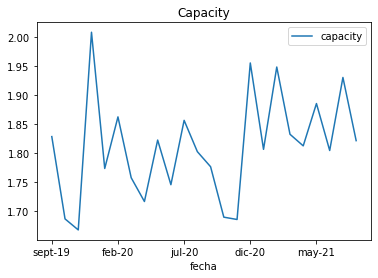

<AxesSubplot:title={'center':'Capacity'}, xlabel='fecha'>

In [0]:
df[['capacity']].plot(title='Capacity')

In [0]:
df.head()

# Holt-Winter Simple

In [0]:
alpha = 0.6
df['HWES1'] = SimpleExpSmoothing(df['capacity']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
df[['capacity','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

# Holt Winter Triple

##### Link: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [0]:

df['capacity_add'] = ExponentialSmoothing(df['capacity'],trend='add',seasonal='add',seasonal_periods=12, initialization_method = 'heuristic').fit().fittedvalues
df['capacity_MUL'] = ExponentialSmoothing(df['capacity'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df[['capacity','capacity_add','capacity_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

#Ajuste de Distribución

In [0]:
from distfit import distfit

#!pip install distfit

In [0]:
dist = distfit()
dist.fit_transform(df['capacity'])


In [0]:
print(dist.summary)
dist.plot()
dist.plot_summary()



# EWMA - Proceso Estocastico (varianza no cte)

In [0]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import norm

In [0]:
df_original = pd.read_csv('/dbfs/FileStore/tables/bronze/FM_ejercicios/capacity.csv', sep = ';', parse_dates=True)
df_original.index = df_original.fecha
df_original = df_original[['capacity']]

df_original.head()

Out[43]:

,capacity
fecha,
sept-19,1.829
oct-19,1.687
nov-19,1.668
dic-19,2.009
ene-20,1.774


In [0]:
# Calculo de la variación porcentual de la variable de interes (pct_change en un periodo)
df_original["vart_pct"] = df_original.capacity.pct_change(1).dropna()
#returns = df['Spread_Orig'].pct_change(1).mul(100)
print(df_original.head())
print(df_original.shape)

capacity ret_spread_orig vart_prct vart_pct
fecha 
sept-19 1.829 NaN NaN NaN
oct-19 1.687 -0.077638 -0.077638 -0.077638
nov-19 1.668 -0.011263 -0.011263 -0.011263
dic-19 2.009 0.204436 0.204436 0.204436
ene-20 1.774 -0.116974 -0.116974 -0.116974
(24, 4)

### EWMA (Exponential Weight Moving Average)

In [0]:
# Parámetros para EWMA
lmbda = 0.94
s = np.var(df_original.vart_pct[1:24], ddof=1)

In [0]:
# Función Generadora de Rezagos
def crealags(base,lag_ini,nrolags):
    for lags in range(lag_ini,  nrolags+lag_ini): #Parte del rezago que definamos, no desde 1
        slag=base.shift(lags).copy(True)
        slag.columns=[str(col) + '_lag'+str(lags) for col in base.columns]
        if lags==lag_ini:#Bloque de datos inicial
            rezagos=pd.concat([slag], axis=1).copy(True)#genera primer bloque de datos 
        else: rezagos=pd.concat([rezagos,slag], axis=1).copy(True) #genera el resto del bloque de datos        
    return rezagos

In [0]:
# Un rezago.
df_original = crealags(df_original,1,1)
df_original.head()

Out[56]:

,capacity_lag1,ret_spread_orig_lag1,vart_prct_lag1,vart_pct_lag1
fecha,,,,
sept-19,NaN,NaN,NaN,NaN
oct-19,1.829,NaN,NaN,NaN
nov-19,1.687,-0.077638,-0.077638,-0.077638
dic-19,1.668,-0.011263,-0.011263,-0.011263
ene-20,2.009,0.204436,0.204436,0.204436


In [0]:
# Modelo EWMA (Exponential Weight Moving Average)
for t in range(1, 24):
    vol_din = lmbda*s + (1-lmbda)*df_original.vart_pct_lag1**2
vol_din

Out[57]: fecha
sept-19 NaN
oct-19 NaN
nov-19 0.006071
dic-19 0.005717
ene-20 0.008217
feb-20 0.006530
mar-20 0.005860
abr-20 0.005900
may-20 0.005742
jun-20 0.005938
jul-20 0.005816
ago-20 0.005952
sept-20 0.005760
oct-20 0.005721
nov-20 0.005853
dic-20 0.005709
ene-21 0.007248
feb-21 0.006057
mar-21 0.006080
abr-21 0.005922
may-21 0.005716
jun-21 0.005806
jul-21 0.005820
ago-21 0.006001
Name: vart_pct_lag1, dtype: float64

In [0]:
# Calculo de la Volatilidad dinamica.
vol_din = np.array(np.sqrt(vol_din))
df_voldin = pd.DataFrame(vol_din, columns = ["vol_din"])
df_voldin.head()

Out[58]:

,vol_din
0,NaN
1,NaN
2,0.077915
3,0.075608
4,0.090646


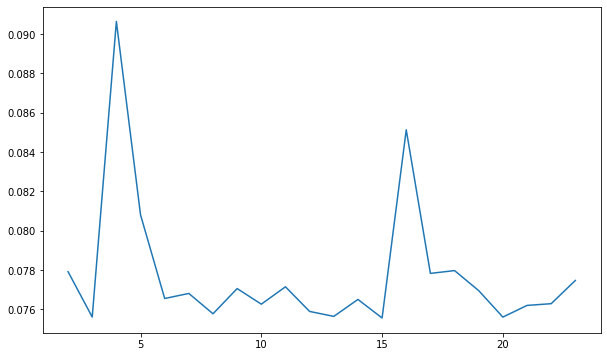

In [0]:
#Gráfico de la Volatilidad Dinamica
df_voldin.vol_din.plot(figsize=(10, 6));

### Proceso Estocastico

In [0]:
# Variación de la Volatilidad
log_variacion = np.log(1 + df_voldin.vol_din.pct_change())

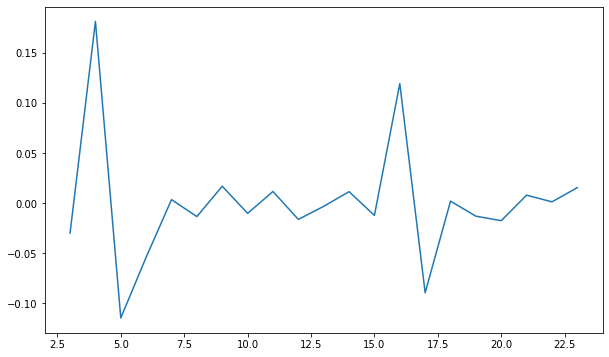

In [0]:
#Gráfico de la Variacion de la Volatilidad
log_variacion.plot(figsize=(10, 6));

In [0]:
#Calculo Estadistico para la Función Generadora Estocastica
u = log_variacion.mean()
var = log_variacion.var()
stdev = log_variacion.std()
drift = u - (0.5*var)

In [0]:
#Parámetros del Proceso Estocastico
num_intervalos_futuros = 7 # número de proyecciones hacia el futuro.
num_iteración = 300 # cantidad de simulaciones en un futuro.
funcion_generadora = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [0]:
s0 = df_voldin.vol_din.iloc[-1]
s0

Out[88]: 0.07746860344078418

In [0]:
#Ultimo punto para comenzar la similación
lista_valor = np.zeros_like(funcion_generadora)
lista_valor[0] = s0

In [0]:
# Generar la Simulación de Montecarlo con la Función Generadora.
for t in range(1, num_intervalos_futuros):
    lista_valor[t] = lista_valor[t - 1] * funcion_generadora[t]

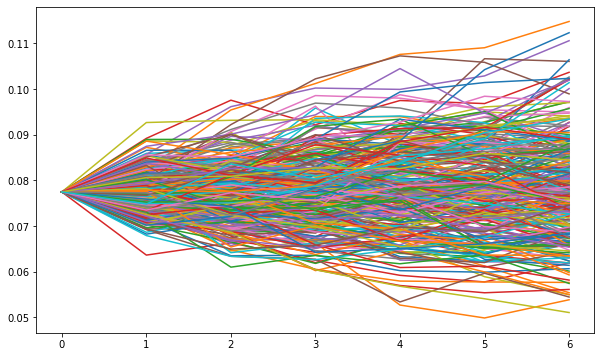

In [0]:
# Gráfico Simulación de Montecarlo
plt.figure(figsize=(10,6))
plt.plot(lista_valor);

In [0]:
simulaciones = pd.DataFrame(lista_valor.transpose(), columns = ["t+1", "t+2", "t+3", "t+4", "t+5", "t+6", "t+7"] )
simulaciones.head(5)

Out[92]:

,t+1,t+2,t+3,t+4,t+5,t+6,t+7
0,0.077469,0.076834,0.074577,0.070393,0.063284,0.062343,0.066023
1,0.077469,0.075784,0.073078,0.080477,0.083452,0.081189,0.074062
2,0.077469,0.079299,0.082176,0.082331,0.081645,0.079602,0.079833
3,0.077469,0.077016,0.067800,0.061958,0.067151,0.063621,0.061900
4,0.077469,0.075685,0.077874,0.079765,0.075985,0.086870,0.100102


In [0]:
# Estadistica de la Simulación para la Generación de Escenarios
p15 = simulaciones.quantile(0.15)
promedio = simulaciones.mean()
mediana = simulaciones.median()
p85 = simulaciones.quantile(0.85)
np.sqrt(promedio), np.sqrt(mediana),np.sqrt(p85)

Out[93]: (t+1 0.278332
 t+2 0.278462
 t+3 0.278318
 t+4 0.279083
 t+5 0.279502
 t+6 0.279327
 t+7 0.279273
 dtype: float64,
 t+1 0.278332
 t+2 0.278251
 t+3 0.278736
 t+4 0.279004
 t+5 0.278452
 t+6 0.279419
 t+7 0.277882
 dtype: float64,
 t+1 0.278332
 t+2 0.287043
 t+3 0.290135
 t+4 0.292855
 t+5 0.296894
 t+6 0.298571
 t+7 0.298704
 Name: 0.85, dtype: float64)

In [0]:
proc_est = pd.DataFrame({'p15': np.array(p15),
                         'Promedio': np.array(promedio) ,
                         'Mediana': np.array(mediana), 
                         'p85':  np.array(p85)}, index= ["t", "t+1", "t+2", "t+3", "t+4", "t+5", "t+6"])
proc_est

Out[94]:

,p15,Promedio,Mediana,p85
t,0.077469,0.077469,0.077469,0.077469
t+1,0.073167,0.077541,0.077424,0.082394
t+2,0.070920,0.077461,0.077694,0.084179
t+3,0.069463,0.077887,0.077843,0.085764
t+4,0.068187,0.078122,0.077535,0.088146
t+5,0.066317,0.078023,0.078075,0.089145
t+6,0.066629,0.077993,0.077218,0.089224


Out[95]:

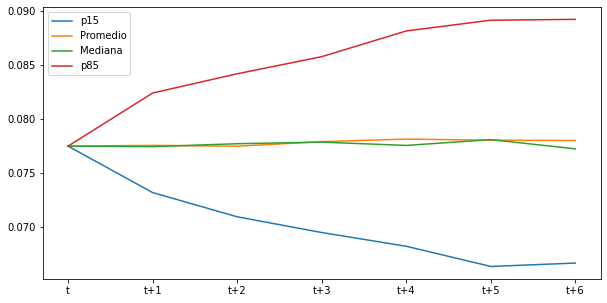

<AxesSubplot:>

In [0]:
proc_est.plot(figsize=(10,5))